In [1]:
#pip install opencv-python

# =====================
# Imports
# =====================
import os
import cv2
import pywt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)
from scipy.signal import stft
from tabulate import tabulate

In [2]:
# =====================
# Custom Transforms
# =====================
class DCTTransform:
    def __call__(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        dct = cv2.dct(np.float32(img))
        dct = cv2.resize(dct, (224, 224))
        dct = np.stack([dct, dct, dct], axis=-1)
        return torch.tensor(dct.transpose(2, 0, 1), dtype=torch.float32)

class STFTTransform:
    def __call__(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        f, t, Zxx = stft(img, nperseg=64)
        magnitude = np.abs(Zxx)
        magnitude = cv2.resize(magnitude, (224, 224))
        magnitude = np.stack([magnitude, magnitude, magnitude], axis=-1)
        return torch.tensor(magnitude.transpose(2, 0, 1), dtype=torch.float32)

class WaveletTransform:
    def __call__(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        coeffs2 = pywt.dwt2(img, 'haar')
        LL, (LH, HL, HH) = coeffs2
        wavelet_img = np.abs(LL)
        wavelet_img = cv2.resize(wavelet_img, (224, 224))
        wavelet_img = np.stack([wavelet_img, wavelet_img, wavelet_img], axis=-1)
        return torch.tensor(wavelet_img.transpose(2, 0, 1), dtype=torch.float32)

class LearnableFrequencyTransform(nn.Module):
    def __init__(self):
        super(LearnableFrequencyTransform, self).__init__()
        self.freq_filter = nn.Parameter(torch.randn(1, 224, 224))

    def forward(self, img):
        if isinstance(img, torch.Tensor):
            img = img.squeeze().numpy()
        img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (224, 224))
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        filtered = img_tensor * self.freq_filter
        filtered = filtered.squeeze(0).detach().numpy()
        filtered = np.stack([filtered, filtered, filtered], axis=-1)
        return torch.tensor(filtered.transpose(2, 0, 1), dtype=torch.float32)

In [3]:
# =====================
# CONFIGURATION
# =====================
config = {
    "epochs": 50,
    "batch_size": 32,
    "lr": 1e-3,
    "early_stopping_patience": 7,
    "dropout": 0.4,
    "num_classes": 5,  # update based on dataset
    "train_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\train",
    "val_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\val",
    "test_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\test",
    "save_dir": r"F:\final project\Capstone Prj\ConNxt",
    "transform_type": "dct",  # options: dct, stft, wavelet, learnable
    "model": "convnext",          # only convnext is supported
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}
os.makedirs(config["save_dir"], exist_ok=True)

# =====================
# Select Transform
# =====================
if config["transform_type"] == "dct":
    transform_fn = DCTTransform()
elif config["transform_type"] == "stft":
    transform_fn = STFTTransform()
elif config["transform_type"] == "wavelet":
    transform_fn = WaveletTransform()
elif config["transform_type"] == "learnable":
    transform_fn = LearnableFrequencyTransform()
else:
    raise ValueError("Invalid transform_type in config")

train_transforms = transforms.Compose([
    transform_fn,
    transforms.Normalize([0.5], [0.5])
])
test_transforms = transforms.Compose([
    transform_fn,
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.ImageFolder(root=config["train_dir"], transform=train_transforms)
val_dataset = datasets.ImageFolder(root=config["val_dir"], transform=test_transforms)
test_dataset = datasets.ImageFolder(root=config["test_dir"], transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

# =====================
# Model Selection
# =====================
def get_model(config):
    if config["model"] == "convnext":
        base = models.convnext_tiny(weights="IMAGENET1K_V1")
        in_features = base.classifier[2].in_features
        base.classifier[2] = nn.Linear(in_features, config["num_classes"])
        return base
    else:
        raise ValueError("Invalid model type in config")

model = get_model(config).to(config["device"])

# =====================
# Loss & Optimizer
# =====================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["lr"])


In [4]:
# =====================
# Training Function
# =====================
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    best_loss = float("inf")
    patience_counter = 0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(config["device"]), labels.to(config["device"])

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(config["device"]), labels.to(config["device"])
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            save_path = os.path.join(config["save_dir"], "convnext_tiny_freq_best.pth")
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Plot curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend(), plt.title("Loss Curve")

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.legend(), plt.title("Accuracy Curve")
    plt.show()

Epoch 1/50: 100%|██████████| 393/393 [25:58<00:00,  3.97s/it]


Epoch 1/50 - Train Loss: 1.2039, Train Acc: 0.6102, Val Loss: 1.1958, Val Acc: 0.6153


Epoch 2/50: 100%|██████████| 393/393 [31:55<00:00,  4.87s/it]


Epoch 2/50 - Train Loss: 1.1912, Train Acc: 0.6148, Val Loss: 1.1858, Val Acc: 0.6153


Epoch 3/50: 100%|██████████| 393/393 [34:46<00:00,  5.31s/it]


Epoch 3/50 - Train Loss: 1.2014, Train Acc: 0.6126, Val Loss: 1.1880, Val Acc: 0.6153


Epoch 4/50: 100%|██████████| 393/393 [26:29<00:00,  4.04s/it]


Epoch 4/50 - Train Loss: 1.1901, Train Acc: 0.6148, Val Loss: 1.1858, Val Acc: 0.6153


Epoch 5/50: 100%|██████████| 393/393 [30:55<00:00,  4.72s/it]


Epoch 5/50 - Train Loss: 1.1878, Train Acc: 0.6148, Val Loss: 1.1860, Val Acc: 0.6153


Epoch 6/50: 100%|██████████| 393/393 [27:46<00:00,  4.24s/it]


Epoch 6/50 - Train Loss: 1.1874, Train Acc: 0.6147, Val Loss: 1.1848, Val Acc: 0.6153


Epoch 7/50: 100%|██████████| 393/393 [25:53<00:00,  3.95s/it]


Epoch 7/50 - Train Loss: 1.1869, Train Acc: 0.6147, Val Loss: 1.1838, Val Acc: 0.6153


Epoch 8/50: 100%|██████████| 393/393 [27:18<00:00,  4.17s/it]


Epoch 8/50 - Train Loss: 1.1868, Train Acc: 0.6147, Val Loss: 1.1838, Val Acc: 0.6153


Epoch 9/50: 100%|██████████| 393/393 [28:24<00:00,  4.34s/it]


Epoch 9/50 - Train Loss: 1.1856, Train Acc: 0.6148, Val Loss: 1.1841, Val Acc: 0.6153


Epoch 10/50: 100%|██████████| 393/393 [28:25<00:00,  4.34s/it]


Epoch 10/50 - Train Loss: 1.1868, Train Acc: 0.6146, Val Loss: 1.1837, Val Acc: 0.6153


Epoch 11/50: 100%|██████████| 393/393 [26:12<00:00,  4.00s/it]


Epoch 11/50 - Train Loss: 1.1862, Train Acc: 0.6148, Val Loss: 1.1845, Val Acc: 0.6153


Epoch 12/50: 100%|██████████| 393/393 [26:08<00:00,  3.99s/it]


Epoch 12/50 - Train Loss: 1.1866, Train Acc: 0.6147, Val Loss: 1.1858, Val Acc: 0.6153


Epoch 13/50: 100%|██████████| 393/393 [26:02<00:00,  3.98s/it]


Epoch 13/50 - Train Loss: 1.1856, Train Acc: 0.6145, Val Loss: 1.1841, Val Acc: 0.6153


Epoch 14/50: 100%|██████████| 393/393 [26:05<00:00,  3.98s/it]


Epoch 14/50 - Train Loss: 1.1856, Train Acc: 0.6147, Val Loss: 1.1833, Val Acc: 0.6153


Epoch 15/50: 100%|██████████| 393/393 [26:01<00:00,  3.97s/it]


Epoch 15/50 - Train Loss: 1.1855, Train Acc: 0.6148, Val Loss: 1.1841, Val Acc: 0.6153


Epoch 16/50: 100%|██████████| 393/393 [25:58<00:00,  3.97s/it]


Epoch 16/50 - Train Loss: 1.1862, Train Acc: 0.6148, Val Loss: 1.1831, Val Acc: 0.6153


Epoch 17/50: 100%|██████████| 393/393 [25:55<00:00,  3.96s/it]


Epoch 17/50 - Train Loss: 1.1855, Train Acc: 0.6148, Val Loss: 1.1851, Val Acc: 0.6153


Epoch 18/50: 100%|██████████| 393/393 [25:51<00:00,  3.95s/it]


Epoch 18/50 - Train Loss: 1.1857, Train Acc: 0.6148, Val Loss: 1.1840, Val Acc: 0.6153


Epoch 19/50: 100%|██████████| 393/393 [25:55<00:00,  3.96s/it]


Epoch 19/50 - Train Loss: 1.1858, Train Acc: 0.6145, Val Loss: 1.1846, Val Acc: 0.6153


Epoch 20/50: 100%|██████████| 393/393 [27:27<00:00,  4.19s/it]


Epoch 20/50 - Train Loss: 1.1864, Train Acc: 0.6148, Val Loss: 1.1846, Val Acc: 0.6153


Epoch 21/50: 100%|██████████| 393/393 [26:40<00:00,  4.07s/it]


Epoch 21/50 - Train Loss: 1.1859, Train Acc: 0.6147, Val Loss: 1.1832, Val Acc: 0.6153


Epoch 22/50: 100%|██████████| 393/393 [25:54<00:00,  3.96s/it]


Epoch 22/50 - Train Loss: 1.1851, Train Acc: 0.6147, Val Loss: 1.1852, Val Acc: 0.6153


Epoch 23/50: 100%|██████████| 393/393 [26:06<00:00,  3.99s/it]


Epoch 23/50 - Train Loss: 1.1855, Train Acc: 0.6148, Val Loss: 1.1831, Val Acc: 0.6153
Early stopping triggered!


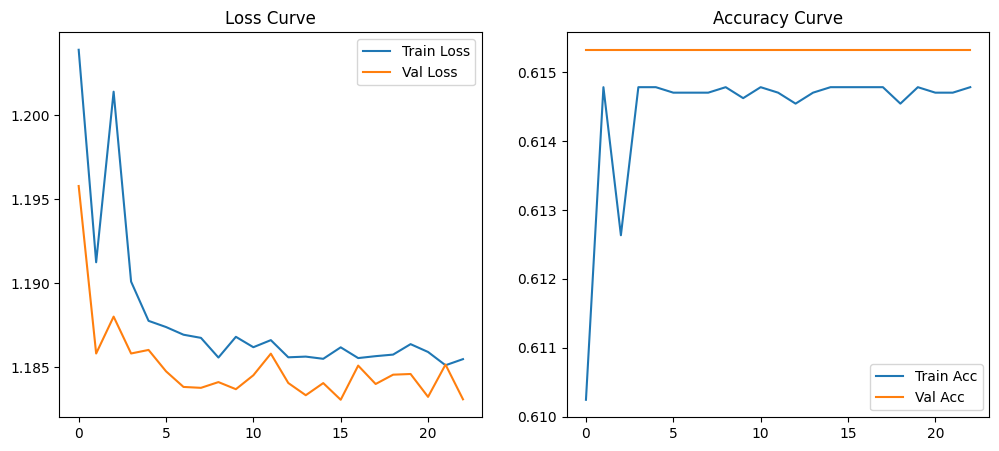


=== Evaluation Results ===
+-----------+---------+
| Metric    |   Value |
+===========+=========+
| Accuracy  |  0.6139 |
+-----------+---------+
| Precision |  0.3768 |
+-----------+---------+
| Recall    |  0.6139 |
+-----------+---------+
| F1 Score  |  0.467  |
+-----------+---------+


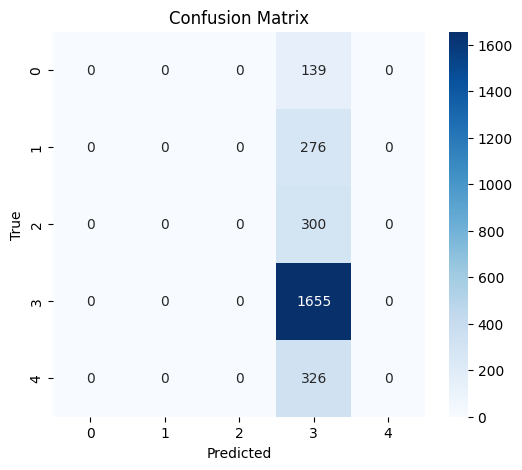

In [5]:
# =====================
# Evaluation Function
# =====================
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(config["device"]), labels.to(config["device"])
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    rec = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    # Print results in table format
    metrics_table = [
        ["Accuracy", f"{acc:.4f}"],
        ["Precision", f"{prec:.4f}"],
        ["Recall", f"{rec:.4f}"],
        ["F1 Score", f"{f1:.4f}"]
    ]
    print("\n=== Evaluation Results ===")
    print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))

    # Confusion Matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=test_loader.dataset.classes,
                yticklabels=test_loader.dataset.classes)
    plt.xlabel("Predicted"), plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# =====================
# Run
# =====================
train_model(model, train_loader, val_loader, criterion, optimizer,
            config["epochs"], config["early_stopping_patience"])

# Load best model for evaluation
best_model_path = os.path.join(config["save_dir"], "convnext_tiny_freq_best.pth")
model.load_state_dict(torch.load(best_model_path, map_location=config["device"]))
evaluate_model(model, test_loader)
